# EPI processing pipeline
This notebook presents the image pre-processing, phase-only conductivity (POC) and phase-only convection-reaction (POCR) tools used for reconstructing conductivity ($\sigma$) from EPI scans, demonstrated on a example subject from the dHCP cohort. 

**Acquisition information:** Imaging was carried out on a 3T ($f_0 = 128$ MHz) Philips Achieva scanner. Spin-echo EPI images were acquired as part of the functional MRI (fMRI) protocol of dHCP dataset. The images had a spatial resolution of $2.15$ mm isotropic and included both anterior-posterior/posterior-anterior (AP/PA) phase encoding directions.

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import json
import yaml
import itertools

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.eprecon import *
from utils.preprocess import *
from utils.tools import *
from utils.plots import *

## 1. Image pre-processing

### 1.a. $B_0$ inhomogeneity correction
EPI images were corrected for $B_0$ inhomogeneity using images acquired in opposite (AP/PA) phase encoding directions using the TOPUP algorithm of FSL. When multiple AP and PA images were available, we extracted the AP and PA images with the lowest $z$-smoothness score. The $z$-smoothness score was defined as the STD of the slice-to-slice difference in the $z$ direction and represented the amount of slice-to-slice motion. The geometric distortion was estimated on the selected magnitude AP and PA images, then the geometric correction was applied to the real and imaginary images separately. The real and imaginary parts were then recombined and we extracted the $B_0$ inhomogeneity corrected phase image

In [2]:
# Set directories
subj_dir = os.path.join(base_dir, "data", "dHCP", "example_subject")
epi_dir = os.path.join(subj_dir, "EPI")
deriv_dir = os.path.join(epi_dir, "derivatives")

# Set file path
mag_path = os.path.join(epi_dir, "mag.nii.gz")
pha_path = os.path.join(epi_dir, "pha.nii.gz")
mag_topup_path = os.path.join(deriv_dir, "mag_topup.nii.gz")
pha_topup_path = os.path.join(deriv_dir, "pha_topup.nii.gz")
topup_info_path = os.path.join(deriv_dir, "info_topup.nii.gz")

# Run TOPUP
topup(
    input_mag_path=mag_path, 
    input_pha_path=pha_path,
    output_mag_path=mag_topup_path, 
    output_pha_path=pha_topup_path,
    pe_dirs=[-1, 1, -1, 1],
    pe_axis=1,
    rd_time=0.04745257979,
    output_info_path=topup_info_path
)

# Load TOPUP information
info = json.load(open(topup_info_path))

# Display selected PA/AP stack indexes
print(f"PA stack index: {info['down']['pe_idx']}")
print(f"AP stack index: {info['up']['pe_idx']}")

PA stack index: 0
AP stack index: 1


### 1.b. Registration of EPI scans to T2w volume
Images were rigdly aligned using MIRTK. We registered available dHCP tissue segmentation to define the brain region of interest (ROI) for conductivity reconstruction in EPI scans.

In [3]:
# Set file path
tse_dir = os.path.join(subj_dir, "TSE")
T2w_path = os.path.join(tse_dir, "T2w.nii.gz")
dof_path = os.path.join(deriv_dir, "EPI_T2w.dof")
T2w_mask_path = os.path.join(tse_dir, "mask.nii.gz")
T2w_dhcp_labels9_path = os.path.join(tse_dir, "dhcp_labels9.nii.gz")
T2w_avg_mask_artefact_path = os.path.join(tse_dir, "derivatives/avg_mask_artefact.nii.gz")
mask_path = os.path.join(deriv_dir, "mask.nii.gz")
dhcp_labels9_path = os.path.join(deriv_dir, "dhcp_labels9.nii.gz")
T2w_mask_artefact_path = os.path.join(deriv_dir, "T2w_mask_artefact.nii.gz")

# Register EPI to volume
mirtk_register(
    input_img1_path=T2w_path,
    input_img2_path=mag_topup_path,
    output_dof_path=dof_path,
)

# Apply transform to masks and labels
mirtk_transform_image(
    input_path=T2w_mask_path,
    input_target_path=mag_topup_path,
    input_invdof_path=dof_path,
    output_path=mask_path,
    label=True,
)
mirtk_transform_image(
    input_path=T2w_dhcp_labels9_path,
    input_target_path=mag_topup_path,
    input_invdof_path=dof_path,
    output_path=dhcp_labels9_path,
    label=True,
)
mirtk_transform_image(
    input_path=T2w_avg_mask_artefact_path,
    input_target_path=mag_topup_path,
    input_invdof_path=dof_path,
    output_path=T2w_mask_artefact_path,
)

### 1.c. Flow void artefact correction on phase image
Phase images presented discontinuities near the straight sinus due to MR signal loss associated with blood flow (i.e. flow void artefact). These discontinuities within the brain ROI lead to spurious oscillations in the conductivity maps reconstructed via finite difference schemes. To overcome this problem, we interpolated the image phase in these regions using radial basis function (RBF) thin-plate spline interpolation. We used the mask artefact created from TSE phase stacks as initialization for EPI phase correction.

In [4]:
# Set file path
pha_corr_path = os.path.join(deriv_dir, "pha_corr.nii.gz")
mask_artefact_path = os.path.join(deriv_dir, "mask_artefact.nii.gz")

# Apply phase artefact correction
correct_phase_artefact(
    input_pha_path=pha_topup_path, 
    input_mask_path=mask_path,
    input_mask_artefact_path=T2w_mask_artefact_path,
    output_pha_path=pha_corr_path,
    output_mask_artefact_path=mask_artefact_path,
    bsp_n=100,
    bsp_axes=[0, 1],
)

RBF interpolation error!


## 2. Electrical properties reconstruction from EPI data

### 2.a. Brain conductivity reconstruction using the phase-only conductivity POC pipeline
We used the POC mapping technique based on the homogeneous Helmholtz equation to reconstruct the conductivity from the transceive phase image. The POC method relies on the local homogeneity assumption which states that the EPs are piecewise constant functions. Partial derivatives were expressed as finite central differences on the image grid. Due to slice-to-slice motion in the EPI phase images, we smoothed the phase images using a 2D slice-by-slice Gaussian filter and the Laplacian was computed only along the $x$ and $y$ axes. The estimated map was then multiplied by a factor of to account for the missing through-slice derivative. This assumes that the effect of conductivity on the phase is isotropic. Finally, the predicted maps were eroded using binary erosion to remove high $\sigma$ values at the boundary of the brain ROI.

**Pipeline parameters:** Gaussian smoothing STD kernel $2.1$ mm, erosion radius $8.4$ mm.

In [5]:
# Set directories
ep_poc_dir = os.path.join(epi_dir, "ep_recon_poc")
deriv_poc_dir = os.path.join(epi_dir, "derivatives_poc")
config_dir = os.path.join(base_dir, "config")

# Set file path
sig_path = os.path.join(ep_poc_dir, "sig.nii.gz")
ep_metrics_path = os.path.join(ep_poc_dir, "ep_metrics.json")
mask_eroded_path = os.path.join(deriv_poc_dir, "mask_eroded.nii.gz")
sig_eroded_path = os.path.join(ep_poc_dir, "sig_eroded.nii.gz")
config_path = os.path.join(config_dir, "dhcp_epi_poc.yaml")

# Load pipeline configuration
kwargs = yaml.safe_load(open(config_path))

# Run POC pipeline
poc_pipeline(
    input_pha_path=pha_corr_path,
    input_mask_path=mask_path,
    input_dhcp_labels9_path=dhcp_labels9_path,
    output_sig_path=sig_path,
    output_ep_metrics_path=ep_metrics_path,
    output_mask_eroded_path=mask_eroded_path,
    output_sig_eroded_path=sig_eroded_path,
    **kwargs,
)

#### Conductivity results

In [6]:
# Load conductivity metrics
ep_metrics = json.load(open(ep_metrics_path))

# Display metrics
print("EPI POCR reconstruction pipeline results:")
print(f"ROI conductivity: {ep_metrics['SIG']:.2f} ± {ep_metrics['SIG_std']:.2f} [S.m⁻¹]")
print(f"Brain conductivity (excluding CSF and ventricles): {ep_metrics['brain_SIG']:.2f} ± {ep_metrics['brain_SIG_std']:.2f} [S.m⁻¹]")
print(f"dGM conductivity: {ep_metrics['dGM_SIG']:.2f} ± {ep_metrics['dGM_SIG_std']:.2f} [S.m⁻¹]")
print(f"WM conductivity: {ep_metrics['WM_SIG']:.2f} ± {ep_metrics['WM_SIG_std']:.2f} [S.m⁻¹]")

EPI POCR reconstruction pipeline results:
ROI conductivity: 1.07 ± 1.34 [S.m⁻¹]
Brain conductivity (excluding CSF and ventricles): 1.09 ± 1.22 [S.m⁻¹]
dGM conductivity: 1.20 ± 0.96 [S.m⁻¹]
WM conductivity: 0.98 ± 1.01 [S.m⁻¹]


#### Diagram representation of the EPI POC pipeline
The POC method leads to spurious oscillations in the reconstructed conductivity at the tissue interface (i.e. where the homogeneity assumption is violated).

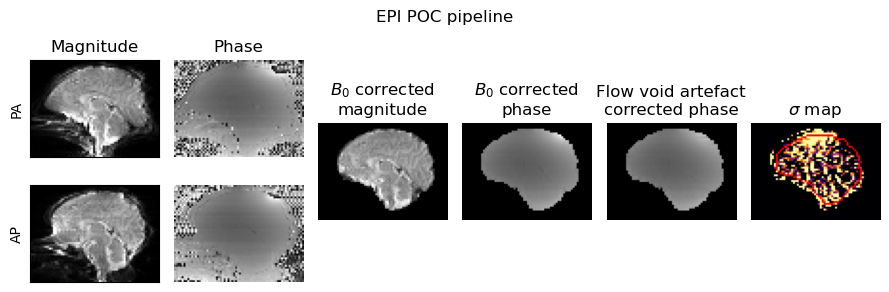

In [7]:
# Set file path
plot_dir = os.path.join(base_dir, "plots", "processing_pipelines")
plot_path = os.path.join(plot_dir, "epi_poc.png")

# Plotting
epi_pipeline_plot(
    input_mag_path=mag_path,
    input_pha_path=pha_path,
    input_mag_topup_path=mag_topup_path,
    input_pha_topup_path=pha_topup_path,
    input_pha_corr_path=pha_corr_path,
    input_sig_path=sig_path,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=33,
    ornt="sagittal",
    view_info={"PA": {"img_index": 0}, "AP": {"img_index": 1}},
    mag_clim=[0, 135],
    pha_clim=[-np.pi, np.pi],
    sig_clim=[0.6, 2.2],
    sig_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(9, 3),
    title="EPI POC pipeline",
    save_imageio=True,
)

### 2.b. Brain conductivity reconstruction using the phase-only convection-reaction (POCR) pipeline
Due to the poor reconstruction performance of the POC pipeline, we used the POCR mapping technique based on the heterogeneous Helmholtz equation to reconstruct the conductivity from the transceive phase image. In our pipeline, the partial derivatives were expressed as finite central differences on the image grid. Considering all voxels within the brain mask, the PDE equation was reformulated as a large sparse linear optimization problem, and its solution was computed using the generalised minimal residual (GMRES) iterative method. The method incorporates a diffusion regularization constant to stabilizes the PDE solution without blurring the internal ROI significantly. Due to slice-to-slice motion in the EPI phase images, we smoothed the phase images using a 2D slice-by-slice Gaussian filter and partial derivatives were computed only along the $x$ and $y$ axes, while the regularisation term included all three spatial directions to ensure spatial cohesion in the predicted $\sigma$ map. The estimated $\sigma$ map was then multiplied by a factor of $1.5$ to account for the missing through-slice gradients and Laplacian. Finally, the predicted $\sigma$ maps were eroded using binary erosion to remove high $\sigma$ values at the boundary of the brain ROI due to unknown boundary conditions in the PDE.

**Pipeline parameters:** Gaussian smoothing STD kernel $2.1$ mm, diffusion regularisation weight $0.05$, erosion radius $8.4$ mm.

In [8]:
# Set directories
ep_pocr_dir = os.path.join(epi_dir, "ep_recon_pocr")
deriv_pocr_dir = os.path.join(epi_dir, "derivatives_pocr")

# Set file path
sig_path = os.path.join(ep_pocr_dir, "sig.nii.gz")
ep_metrics_path = os.path.join(ep_pocr_dir, "ep_metrics.json")
mask_eroded_path = os.path.join(deriv_pocr_dir, "mask_eroded.nii.gz")
sig_eroded_path = os.path.join(ep_pocr_dir, "sig_eroded.nii.gz")
config_path = os.path.join(config_dir, "dhcp_epi_pocr.yaml")

# Load pipeline configuration
kwargs = yaml.safe_load(open(config_path))

# Run POCR pipeline
pocr_pipeline(
    input_pha_path=pha_corr_path,
    input_mask_path=mask_path,
    input_dhcp_labels9_path=dhcp_labels9_path,
    output_sig_path=sig_path,
    output_ep_metrics_path=ep_metrics_path,
    output_mask_eroded_path=mask_eroded_path,
    output_sig_eroded_path=sig_eroded_path,
    **kwargs,
)

#### Conductivity results

In [9]:
# Load conductivity metrics
ep_metrics = json.load(open(ep_metrics_path))

# Display metrics
print("EPI POCR reconstruction pipeline results:")
print(f"ROI conductivity: {ep_metrics['SIG']:.2f} ± {ep_metrics['SIG_std']:.2f} [S.m⁻¹]")
print(f"Brain conductivity (excluding CSF and ventricles): {ep_metrics['brain_SIG']:.2f} ± {ep_metrics['brain_SIG_std']:.2f} [S.m⁻¹]")
print(f"dGM conductivity: {ep_metrics['dGM_SIG']:.2f} ± {ep_metrics['dGM_SIG_std']:.2f} [S.m⁻¹]")
print(f"WM conductivity: {ep_metrics['WM_SIG']:.2f} ± {ep_metrics['WM_SIG_std']:.2f} [S.m⁻¹]")

EPI POCR reconstruction pipeline results:
ROI conductivity: 1.24 ± 0.36 [S.m⁻¹]
Brain conductivity (excluding CSF and ventricles): 1.24 ± 0.36 [S.m⁻¹]
dGM conductivity: 1.21 ± 0.14 [S.m⁻¹]
WM conductivity: 1.25 ± 0.37 [S.m⁻¹]


#### Diagram representation of the EPI POCR pipeline
The POCR pipeline provide more robust extraction of brain conductivity than the POC method.

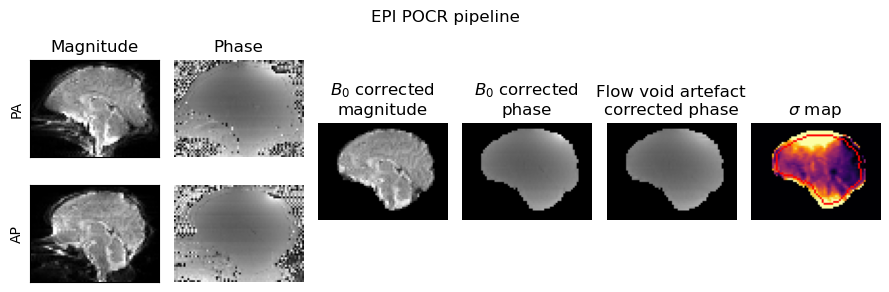

In [10]:
# Set file path
plot_path = os.path.join(plot_dir, "epi_pocr.png")

# Plotting
epi_pipeline_plot(
    input_mag_path=mag_path,
    input_pha_path=pha_path,
    input_mag_topup_path=mag_topup_path,
    input_pha_topup_path=pha_topup_path,
    input_pha_corr_path=pha_corr_path,
    input_sig_path=sig_path,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=33,
    ornt="sagittal",
    view_info={"PA": {"img_index": 0}, "AP": {"img_index": 1}},
    mag_clim=[0, 135],
    pha_clim=[-np.pi, np.pi],
    sig_clim=[0.6, 2.2],
    sig_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(9, 3),
    title="EPI POCR pipeline",
    save_imageio=True,
)

## 3. Impact of POCR pipeline parameters on electrical properties reconstruction

### 3.a Tuning of Gaussian smoothing (*$\Sigma$*) and diffusion regularization weight (*c*)
Smoothing is a typical pre-processing step in all EPT pipelines to improve the robustness of the EPs reconstruction, as derivatives involved in Helmholtz equation are very sensitive to noise in the high frequency region of the Fourier spectrum. However, this also exacerbates boundary errors; therefore, there is a trade-off between signal to noise ratio (SNR) and tissue contrast in EPs maps. Similarly, the amount of regularisation in the POCR pipeline is controlled by the diffusion constant $c$, and there is there is a trade-off between the accuracy and the stability of the solution when choosing its value.

In [11]:
# Set directory
tuning_dir = os.path.join(epi_dir, "ep_recon_pocr_tuning")

# Set parameters grid
gs_sigmas = [0.5375, 1.075, 1.6125, 2.15, 2.6875]
diff_reg_ws = [0.01, 0.05, 0.1]
sig_paths = []

# Iter over parameters
for i, (gs_sigma, diff_reg_w) in enumerate(itertools.product(gs_sigmas, diff_reg_ws)):
    # Set file path
    sig_path = os.path.join(tuning_dir, f"sig_0_{i}.nii.gz")
    sig_paths += [sig_path]

    # Set parameters
    kwargs = yaml.safe_load(open(config_path))
    kwargs["gs_sigma"] = gs_sigma
    kwargs["diff_reg_w"] = diff_reg_w

    # Run POCR pipeline
    pocr_pipeline(
        input_pha_path=pha_corr_path,
        input_mask_path=mask_path,
        output_sig_path=sig_path,
        **kwargs,
    )

# Reshape array
m, k = len(gs_sigmas), len(diff_reg_ws)
sig_paths = [sig_paths[i*k:(i+1)*k] for i in range(m)]

#### Parameter tuning plot

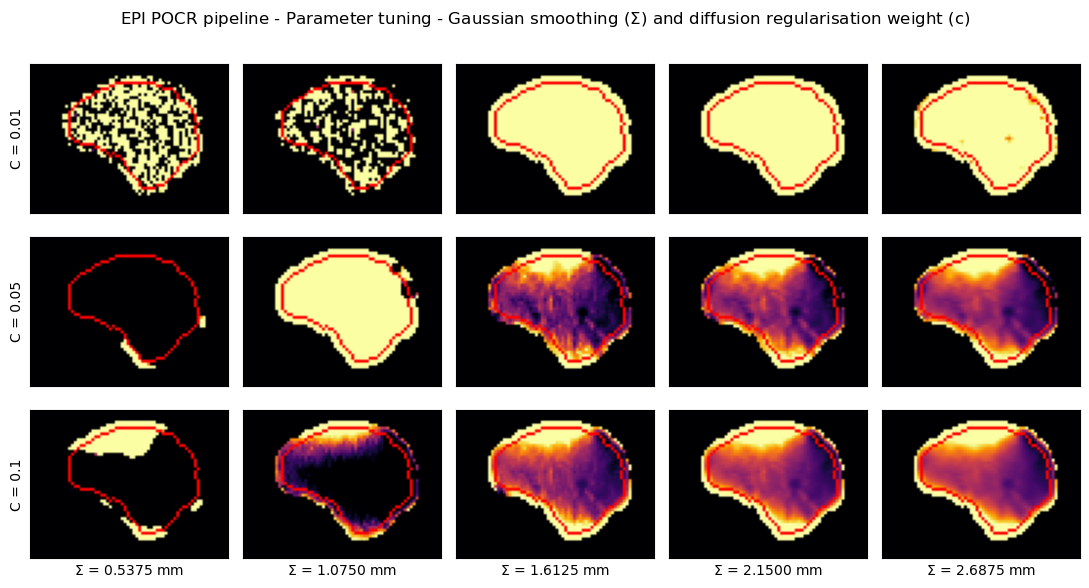

In [12]:
# Set file path
plot_path = os.path.join(plot_dir, "epi_pocr_tuning_a.png")
gs_sigma_labels = [f"{gs_sigma:.4f} mm" for gs_sigma in gs_sigmas]

# Plotting
parameter_tuning_plot(
    input_sig_paths=sig_paths,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=33,
    ornt="sagittal",
    param_info={r"$\sigma$": gs_sigma_labels, "c": diff_reg_ws},
    ep_clim=[0.6, 2.2],
    ep_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(11, 6),
    title=r"EPI POCR pipeline - Parameter tuning - Gaussian smoothing ($\Sigma$) and diffusion regularisation weight (c)",
    save_imageio=True,
)

### 3.b. Effect of 2D vs. 3D Gaussian smoothing and diffusion regularisation

In [13]:
# Set parameters grid
gs_axes = [[0,1], [0,1,2]]
diff_reg_axes = [[0,1], [0,1,2]]
sig_paths = []

# Iter over parameters
for i, (gs_ax, diff_reg_ax) in enumerate(itertools.product(gs_axes, diff_reg_axes)):
    # Set file path
    sig_path = os.path.join(tuning_dir, f"sig_1_{i}.nii.gz")
    sig_paths += [sig_path]

    # Set parameters
    kwargs = yaml.safe_load(open(config_path))
    kwargs["gs_axes"] = gs_ax
    kwargs["diff_reg_axes"] = diff_reg_ax

    # Run POCR pipeline
    pocr_pipeline(
        input_pha_path=pha_corr_path,
        input_mask_path=mask_path,
        output_sig_path=sig_path,
        **kwargs,
    )

# Reshape array
m, k = len(gs_axes), len(diff_reg_axes)
sig_paths = [sig_paths[i*k:(i+1)*k] for i in range(m)]

#### Parameter tuning plot

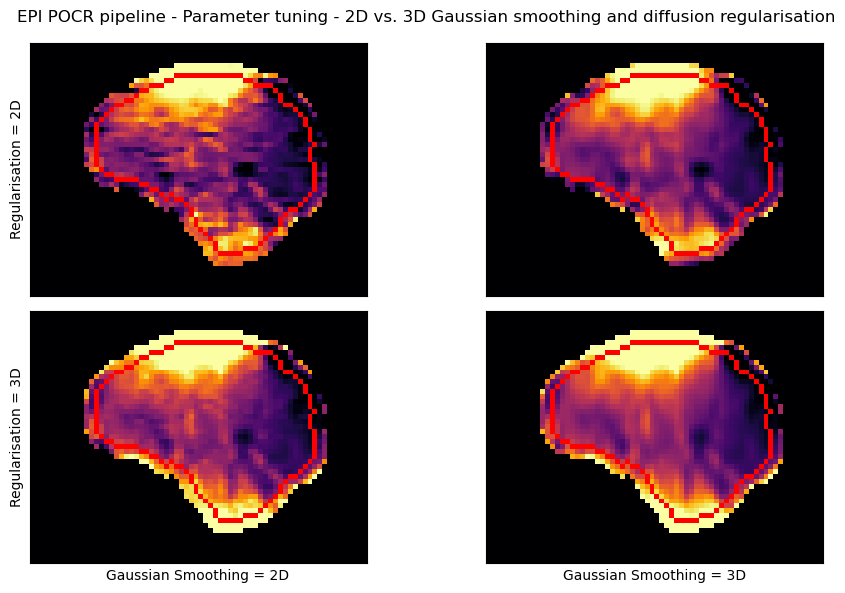

In [14]:
# Set file path
plot_path = os.path.join(plot_dir, "epi_pocr_tuning_b.png")

# Plotting
parameter_tuning_plot(
    input_sig_paths=sig_paths,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=33,
    ornt="sagittal",
    param_info={"Gaussian smoothing": ["2D", "3D"], "Regularisation": ["2D", "3D"]},
    ep_clim=[0.6, 2.2],
    ep_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(10, 6),
    title="EPI POCR pipeline - Parameter tuning - 2D vs. 3D Gaussian smoothing and diffusion regularisation",
    save_imageio=True,
)